<a href="https://colab.research.google.com/github/mellalbuquerque/fashiondata/blob/main/Spring_2025_Ready_To_Wear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [7]:
# Importação de Bibliotecas
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import re
import unicodedata
import pandas as pd
import random

# Carregar modelo spaCy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Ajuste do tokenizer para preservar hífens
infixes = nlp.Defaults.infixes
infixes = [pattern for pattern in infixes if "-" not in pattern]
infix_re = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Retrieving data

In [2]:
# URL atualizada para Spring 2025 Ready-to-Wear
url = 'https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear'

# Raspagem de links das páginas de shows
response_show = requests.get(url)
list_fashion_shows = []
if response_show.status_code == 200:
    soup_show = BeautifulSoup(response_show.text, 'html.parser')
    elements = soup_show.find_all('a', class_='NavigationInternalLink-cWEaeo')

    for element in elements:
        if 'fashion-shows' in element['href']:
            list_fashion_shows.append(element['href'])

articles = []

# Percorrendo cada link e armazenando o conteúdo
for url_fashion_show in list_fashion_shows:
    full_url = 'https://www.vogue.com' + url_fashion_show
    response_show = requests.get(full_url)

    if response_show.status_code == 200:
        soup_show = BeautifulSoup(response_show.text, 'html.parser')
        show_text_element = soup_show.find('div', class_='body__inner-container')

        try:
            articles.append(show_text_element.text)
            print(f'Sucesso: {full_url}')
        except:
            print(f'Erro: {full_url}')



Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/apotts
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/a-l-c
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/a-w-a-k-e
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/aaron-esh
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/abra
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/acne-studios
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/adam-lippes
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/adeam
Erro: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/agl
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/ahluwalia-studio
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/akris
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/azzedine-alaia
Sucesso: https://www.vogue.com/fashion-s

In [3]:
print(articles)

['Aaron Potts returned to the New York Men’s Day showcase this morning after a season away. “Men’s Day to me is like a family reunion,” he said. “We all come here to get together and do our thing, and we know what we’re doing.”Potts had two ideas in mind for spring: The color blue—its textures, shades, and a variety of iterations from patchwork and denim to fringe—and the goal of keeping his clothes exciting but not too precious. “It’s about making and finding that special element in an everyday thing,” he said.Taking a hue as versatile as blue was an effective starting point for Potts, and his ingenuity in approaching its many applications lent his collection a good dose of dimension, particularly after his blackout fall lineup. In his silhouettes, Potts continued to expand on his exploration of utility in the context of everyday city sophistication, finding more success in his oversized shirting and his riffs on quintessential workwear styles. A pair of coveralls, which he shaped loo

Pré-processamento de texto

In [4]:
# Função de limpeza de texto
def clean_text(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Tokenização e lematização (com ajuste para palavras hifenizadas)
def lemmatize_article(text):
    doc = nlp(text)
    return [
        token.lemma_ if token.lemma_ != "-PRON-" else token.text  # Evita problemas com pronomes
        for token in doc
        if not token.is_stop and not token.is_punct
    ]


# Combinar lemmas em strings para n-gramas
def combine_lemmas(preprocessed_articles):
    return [" ".join(article) for article in preprocessed_articles]

# Pipeline completo para processamento de artigos
def preprocess_articles(articles):
    cleaned_articles = [clean_text(article) for article in articles]
    lemmatized_articles = [lemmatize_article(article) for article in cleaned_articles]
    combined_articles = combine_lemmas(lemmatized_articles)
    return combined_articles

preprocessed_articles = preprocess_articles(articles)


In [5]:
# 🔹 TESTE FINAL: PRESERVAÇÃO DE PALAVRAS HIFENIZADAS 🔹
# Criamos um pequeno texto de teste contendo palavras compostas com hífen
test_text = "One-piece, maxi-dress e off-shoulder-dress são itens essenciais para a moda."

# Aplicamos o pré-processamento
cleaned_test_text = clean_text(test_text)
lemmatized_test_text = lemmatize_article(cleaned_test_text)

# 🔍 Exibimos o resultado
print("\n📌 Texto original:", test_text)
print("📌 Texto limpo:", cleaned_test_text)
print("📌 Texto lematizado:", " ".join(lemmatized_test_text))

# Agora verificamos se as palavras hifenizadas ainda estão corretas
print("\n🔍 Teste final de palavras hifenizadas no corpus:")
for word in ["one-piece", "maxi-dress", "off-shoulder-dress"]:
    if word in lemmatized_test_text:
        print(f"✅ {word} foi mantido corretamente!")
    else:
        print(f"❌ {word} foi perdido! 🚨")



📌 Texto original: One-piece, maxi-dress e off-shoulder-dress são itens essenciais para a moda.
📌 Texto limpo: one-piece maxi-dress e off-shoulder-dress sao itens essenciais para a moda
📌 Texto lematizado: one-piece maxi-dress e off-shoulder-dress sao itens essenciais para moda

🔍 Teste final de palavras hifenizadas no corpus:
✅ one-piece foi mantido corretamente!
✅ maxi-dress foi mantido corretamente!
✅ off-shoulder-dress foi mantido corretamente!


# **Dicionário de moda**

In [12]:
# 📌 **1️⃣ Definição do Dicionário Único de Moda**
fashion_categories = {
    "Fabrics": ["chiffon", "linen", "silk", "cotton", "seersucker", "muslin", "voile", "poplin",
                "organza", "tulle", "satin", "georgette", "crepe", "gauze", "mesh", "terrycloth", "raffia",
                "crochet", "knit", "lace", "broderie-anglaise", "eyelet", "lightweight-wool", "suede", "velvet",
                "airy-cotton", "sheer", "bamboo", "denim", "stonewashed", "distressed", "leather", "canvas", "wool", "synthetic-fibre"
                "pleated", "jacquard", "embroidered", "tweed", "crystal-embellished", "metallic-thread",
                "lamé", "lurex", "velvet", "batiste", "corduroy", "flannel", "gabardine", "jersey", "mohair", "moleskin"],

    "Clothing": ["caftan", "pareo", "sarong", "sundress", "maxi-dress", "midi-dress", "mini-dress", "overcoat", "pantyhose", "stockings",
                 "halter-dress", "slip-dress", "wrap-dress", "flowy-dress", "off-shoulder-dress", "t-shirt", "shirt",
                 "wide-leg-pants", "palazzo-pants", "culottes", "cropped-pants", "bathing-suit", "suit", "sweater",
                 "high-waisted-shorts", "bermuda-shorts", "wrap-skirt", "pleated-skirt", "nightgown"
                 "kimono-cover-up", "bandeau-top", "one-piece", "swimsuit", "high-waisted-bikini"],

    "Colors": ["ivory", "beige", "sand", "camel", "peach", "coral", "turquoise", "aqua", "seafoam", "Turquoise",
               "Magenta", "Lime-Green", "Coral", "Fuchsia", "Gold", "Ivory", "Tuscan-Sun", "Ballet-Slipper", "Raisin",
               "Pickle", "Penny", "Spider", "Red", "Orange", "Yellow", "Green", "Blue", "Purple", "Pink", "Brown", "Black",
               "White", "ocean-blue", "powder-blue", "sky-blue", "sunset-hues", "butter-yellow", "fuchsia",
               "tangerine", "bronze", "gold", "champagne", "silver", "terracotta", "emerald"],

    "Prints & Patterns": ["floral", "tropical", "palm-leaf", "seashell-motif", "spotted", "tartan",
                          "ocean-waves", "watercolor", "ikat", "tie-dye", "solid", "striped",
                          "nautical-stripes", "geometric", "polka-dots", "herringbone", "houndstooth",
                          "paisley", "chevron", "glen-plaid", "windowpane", "gingham", "ombre",
                          "baroque", "abstract", "marble", "animal-print", "zebra-print", "leopard-print",
                          "snake-print", "camouflage", "patchwork", "batik", "damask", "jacquard",
                          "chinoiserie", "mosaic", "art-deco", "swirl", "cloud-print", "gradient",
                          "stars", "moon-phases", "sunburst", "argyle", "checkerboard", "lace-pattern",
                          "devoré", "burnout", "brocade", "textured", "embossed", "metallic-thread",
                          "embroidered", "mesh-pattern", "laser-cut", "foil-print"],

    "Shoes": ["boots", "sandals", "flip-flops", "sneakers", "high-heels", "heels", "flat-sandals", "platform-sandals", "t-strap", "slipper",
              "gladiator-sandals", "ballerinas-flats", "slingback", "moccasin", "mary-janes", "oxford", "chukkas", "ankle-boots",
              "army-boots", "dress-boots", "trekking-boots", "wellington-boots", "work-boots", "slip-on", "loafers", "mules", "trainer-shoes",
              "wedges", "peep-toes", "stilettos", "clogs"],

    "Accessories": ["woven-sandals", "espadrilles", "raffia-hat", "sunhat", "straw-hat", "bracelets", "watch", "bow-tie", "beret",
                    "sunglasses", "cat-eye-sunglasses", "basket-bag", "crossbody-bag", "hair-clips", "scarf", "briefcase",
                    "shell-jewelry", "turquoise-necklace", "hoops", "stacked-bangles", "bag", "belt", "ring", "necklace",
                    "earring", "hat", "cap", "bonnet", "sunglass", "sunglasses", "glasses", "mittens"]
}


N-gramas gerais

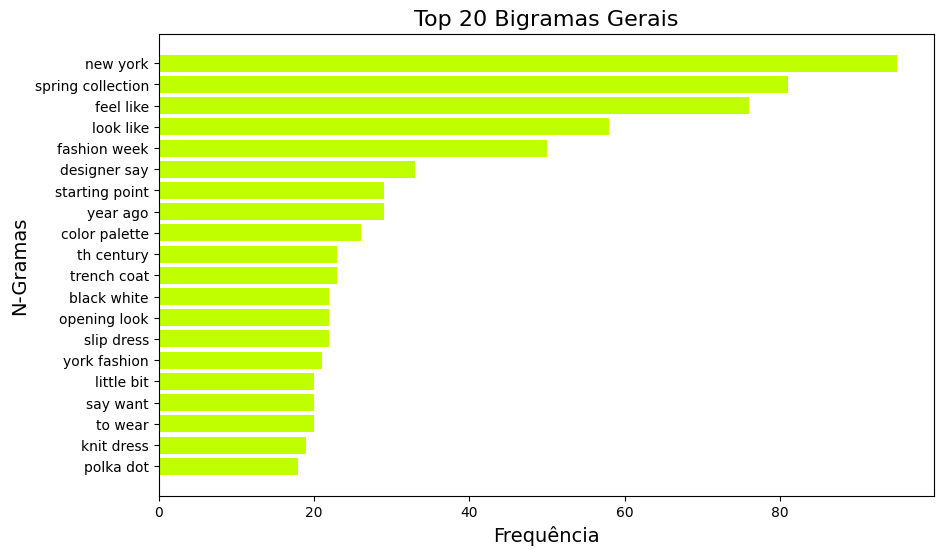

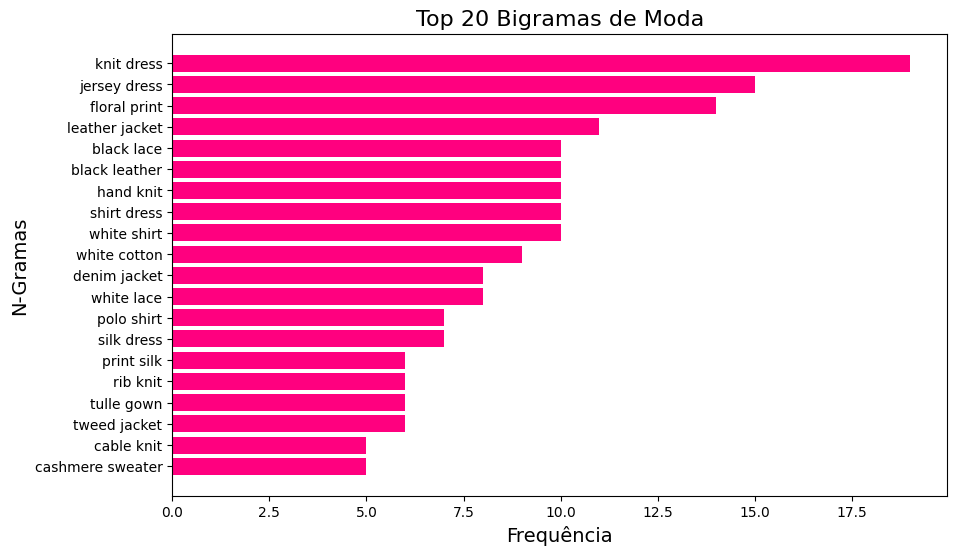

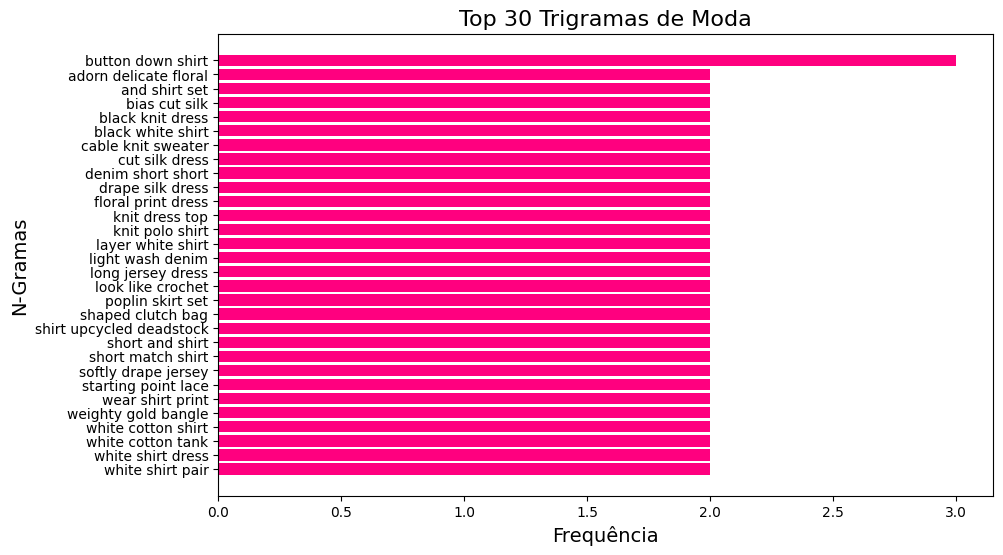

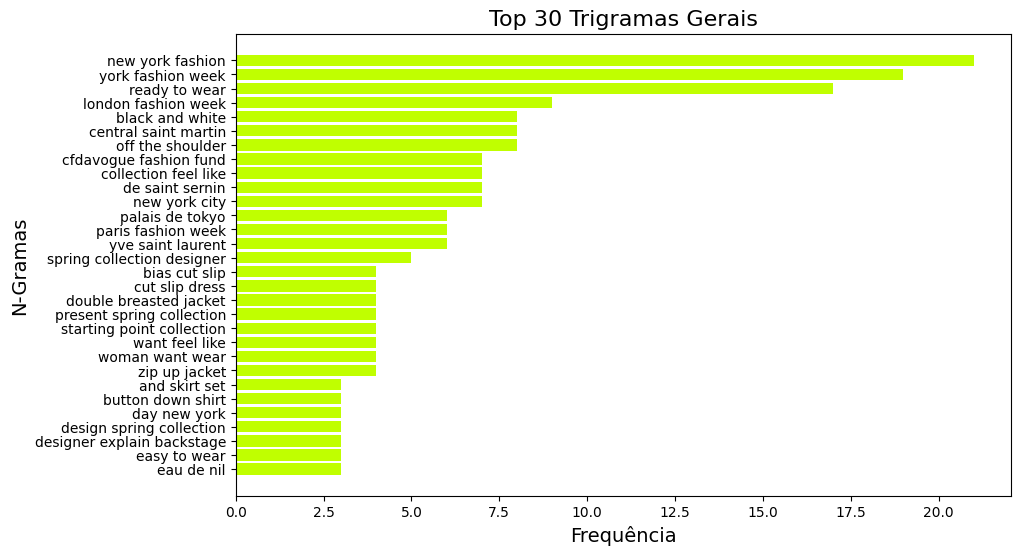

In [18]:
# 📌 ** Função para Gerar N-Gramas e Exibir**
def generate_ngrams(corpus, n, top_k=20, filter_fashion=False):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))

    if filter_fashion:
        fashion_set = set(word for category in fashion_categories.values() for word in category)
        ngram_counts = {ngram: count for ngram, count in ngram_counts.items() if any(word in fashion_set for word in ngram.split())}

    return Counter(ngram_counts).most_common(top_k)

def plot_ngrams_color(ngrams, title, color):
    """
    Plota os n-gramas usando uma cor específica.
    - `ngrams`: lista de tuplas (n-grama, frequência)
    - `title`: título do gráfico
    - `color`: cor para as barras (Neon Lime Green para gerais, Neon Pink para moda)
    """
    # Converter os n-gramas para um DataFrame
    df = pd.DataFrame(ngrams, columns=["N-Grama", "Frequência"])

    plt.figure(figsize=(10, 6))
    plt.barh(df["N-Grama"], df["Frequência"], color=color)
    plt.xlabel("Frequência", fontsize=14)
    plt.ylabel("N-Gramas", fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Para que a maior frequência fique no topo
    plt.show()

# Exibir gráficos com cores distintas:
plot_ngrams_color(general_bigrams, "Top 20 Bigramas Gerais", "#C0FF00")
plot_ngrams_color(fashion_bigrams, "Top 20 Bigramas de Moda", "#FF007F")
plot_ngrams_color(fashion_trigrams, "Top 30 Trigramas de Moda", "#FF007F")
plot_ngrams_color(general_trigrams, "Top 30 Trigramas Gerais", "#C0FF00")


Nuvem de palavras

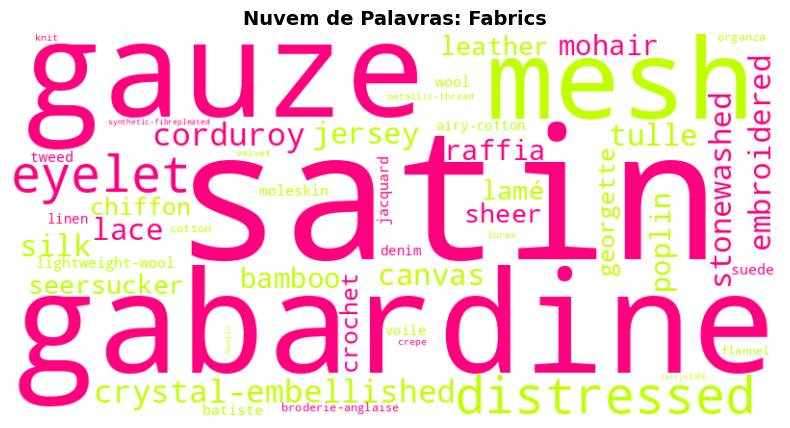

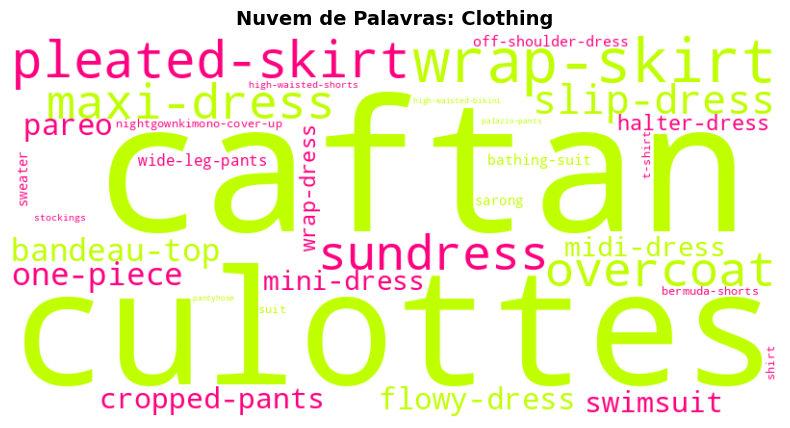

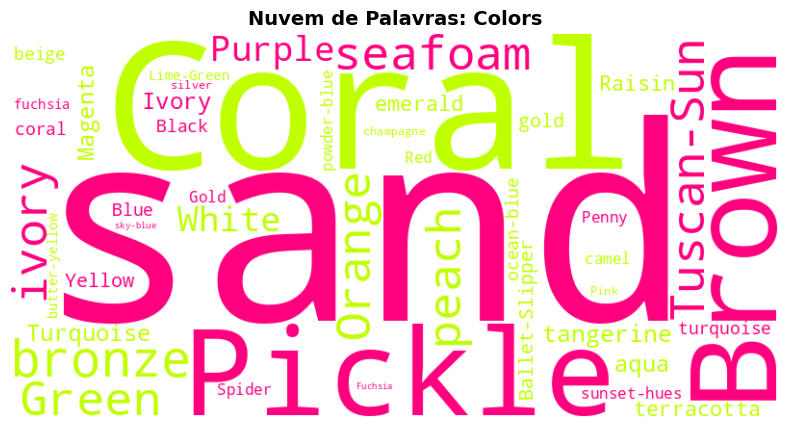

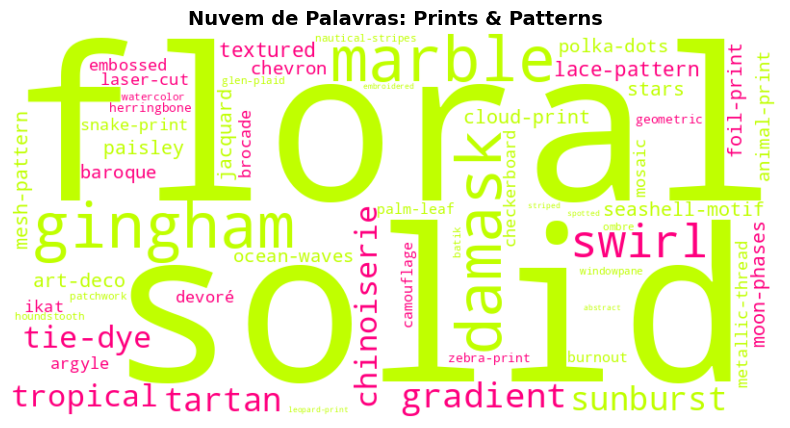

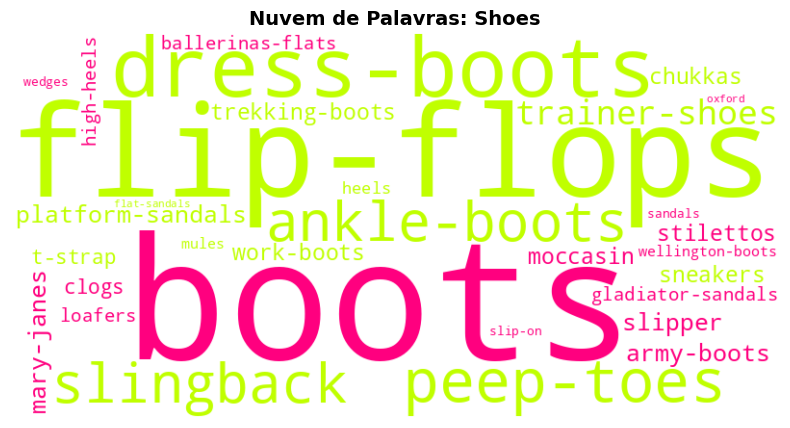

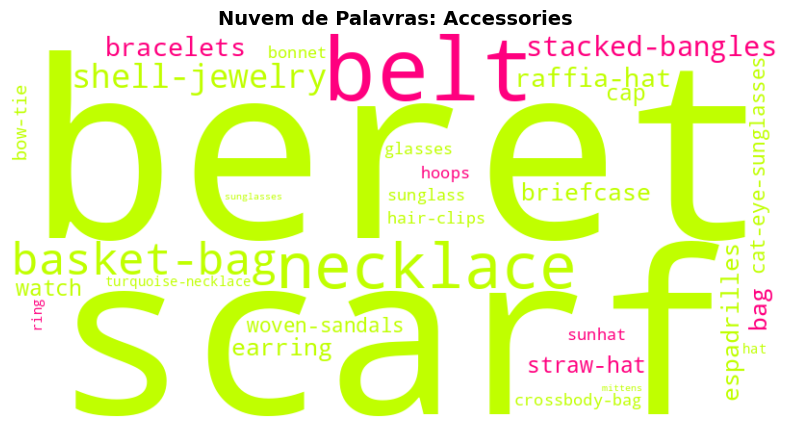

In [15]:
# 📌 **3️⃣ Função para Criar Nuvem de Palavras**
def color_function(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(["#FF007F", "#C0FF00"])  # Neon Pink e Neon Lime Green

def criar_nuvem(categoria, palavras):
    contagem = Counter({word: random.randint(1, 10) for word in palavras})
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        color_func=color_function
    ).generate_from_frequencies(contagem)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuvem de Palavras: {categoria}", fontsize=14, fontweight="bold", color="black")
    plt.show()

# 📌 **4️⃣ Gerar Nuvem de Palavras para Cada Categoria**
for categoria, palavras in fashion_categories.items():
    criar_nuvem(categoria, palavras)
